
Training Model 1: Deskewed Red
Epoch 1/3, Loss: 6.6902
Epoch 2/3, Loss: 6.0630
Epoch 3/3, Loss: 6.0081
Model 1: Deskewed Red: Accuracy=0.20%, Latency=4.09ms, Throughput=244.59 img/s

Training Model 2: Deskewed Grey
Epoch 1/3, Loss: 6.7034
Epoch 2/3, Loss: 6.0642
Epoch 3/3, Loss: 6.0126
Model 2: Deskewed Grey: Accuracy=0.60%, Latency=0.89ms, Throughput=1120.59 img/s

Training Model 3: Red+Denoise
Epoch 1/3, Loss: 6.6807
Epoch 2/3, Loss: 6.0588
Epoch 3/3, Loss: 6.0087
Model 3: Red+Denoise: Accuracy=0.60%, Latency=1.52ms, Throughput=659.14 img/s

Training Model 4: PreDenoise Red
Epoch 1/3, Loss: 6.6997
Epoch 2/3, Loss: 6.0664
Epoch 3/3, Loss: 6.0104
Model 4: PreDenoise Red: Accuracy=0.20%, Latency=1.14ms, Throughput=876.18 img/s


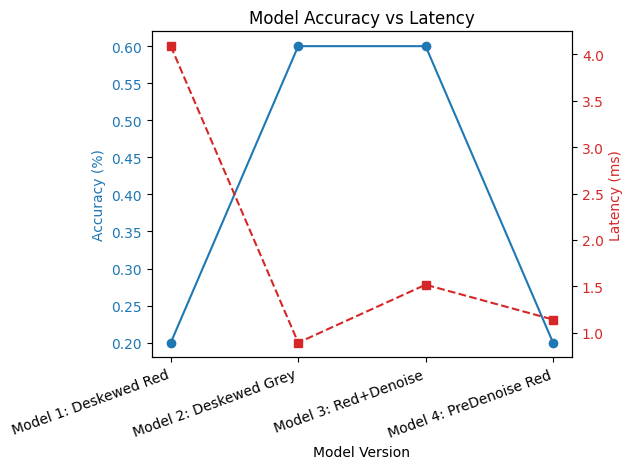

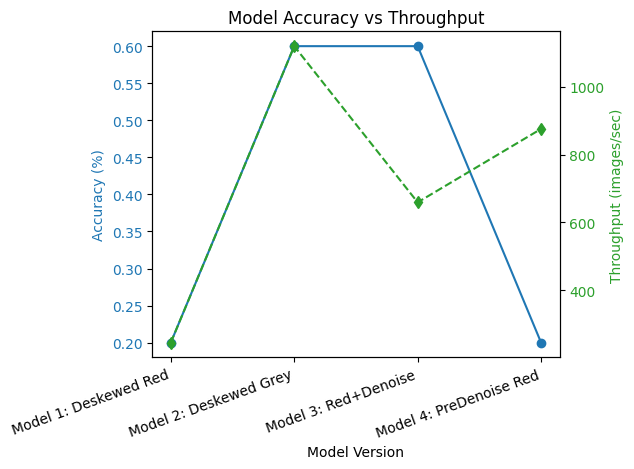

In [2]:
# ============================================================
# Automated OCR Model Training + Evaluation
# Works with lansinuote/ocr_id_card dataset (character-level encoding)
# ============================================================

import os
import time
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from datasets import load_dataset
from torch.utils.data import DataLoader, Dataset

# ------------------------------------------------------------
# Configuration
# ------------------------------------------------------------
SAVE_DIR = Path("saved_model")
SAVE_DIR.mkdir(exist_ok=True)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
IMG_W, IMG_H = 128, 32
EPOCHS = 3
BATCH_SIZE = 8

# ------------------------------------------------------------
# Shared CNN-LSTM Model Definition
# ------------------------------------------------------------
class OCRNet(nn.Module):
    def __init__(self, nclass=80):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, 3, 1, 1), nn.ReLU(), nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, 3, 1, 1), nn.ReLU(), nn.MaxPool2d(2, 2)
        )
        self.lstm = nn.LSTM(64 * 8, 128, num_layers=2,
                             bidirectional=True, batch_first=True)
        self.fc = nn.Linear(256, nclass)

    def forward(self, x):
        x = self.conv(x)
        b, c, h, w = x.size()
        x = x.permute(0, 3, 1, 2).reshape(b, w, -1)
        x, _ = self.lstm(x)
        x = self.fc(x)
        return x.mean(dim=1)

# ------------------------------------------------------------
# Preprocessing Functions
# ------------------------------------------------------------
def deskew_red(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 50, 150)
    lines = cv2.HoughLines(edges, 1, np.pi / 180, 200)
    angle = 0
    if lines is not None:
        angles = [theta for rho, theta in lines[:, 0]]
        angle = (np.mean(angles) - np.pi / 2) * 180 / np.pi
    (h, w) = img.shape[:2]
    M = cv2.getRotationMatrix2D((w // 2, h // 2), angle, 1)
    img = cv2.warpAffine(img, M, (w, h), flags=cv2.INTER_CUBIC)
    b, g, r = cv2.split(img)
    red_only = cv2.merge([np.zeros_like(r), np.zeros_like(r), r])
    gray = cv2.cvtColor(red_only, cv2.COLOR_BGR2GRAY)
    return cv2.resize(gray, (IMG_W, IMG_H))

def deskew_grey(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 50, 150)
    lines = cv2.HoughLines(edges, 1, np.pi / 180, 200)
    angle = 0
    if lines is not None:
        angles = [theta for rho, theta in lines[:, 0]]
        angle = (np.mean(angles) - np.pi / 2) * 180 / np.pi
    (h, w) = img.shape[:2]
    M = cv2.getRotationMatrix2D((w // 2, h // 2), angle, 1)
    img = cv2.warpAffine(img, M, (w, h), flags=cv2.INTER_CUBIC)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return cv2.resize(gray, (IMG_W, IMG_H))

def deskew_red_denoise(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 50, 150)
    lines = cv2.HoughLines(edges, 1, np.pi / 180, 200)
    angle = 0
    if lines is not None:
        angles = [theta for rho, theta in lines[:, 0]]
        angle = (np.mean(angles) - np.pi / 2) * 180 / np.pi
    (h, w) = img.shape[:2]
    M = cv2.getRotationMatrix2D((w // 2, h // 2), angle, 1)
    img = cv2.warpAffine(img, M, (w, h), flags=cv2.INTER_CUBIC)
    b, g, r = cv2.split(img)
    red_only = cv2.merge([np.zeros_like(r), np.zeros_like(r), r])
    gray = cv2.cvtColor(red_only, cv2.COLOR_BGR2GRAY)
    denoiseImg = cv2.fastNlMeansDenoising(gray, h=10)
    return cv2.resize(denoiseImg, (IMG_W, IMG_H))

def predenoise_red(img):
    img = cv2.fastNlMeansDenoisingColored(img, None, 10, 10, 7, 21)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 50, 150)
    lines = cv2.HoughLines(edges, 1, np.pi / 180, 200)
    angle = 0
    if lines is not None:
        angles = [theta for rho, theta in lines[:, 0]]
        angle = (np.mean(angles) - np.pi / 2) * 180 / np.pi
    (h, w) = img.shape[:2]
    M = cv2.getRotationMatrix2D((w // 2, h // 2), angle, 1)
    img = cv2.warpAffine(img, M, (w, h), flags=cv2.INTER_CUBIC)
    b, g, r = cv2.split(img)
    red_only = cv2.merge([np.zeros_like(r), np.zeros_like(r), r])
    gray = cv2.cvtColor(red_only, cv2.COLOR_BGR2GRAY)
    return cv2.resize(gray, (IMG_W, IMG_H))

# ------------------------------------------------------------
# Dataset Wrapper (uses char2idx instead of label_encoder)
# ------------------------------------------------------------
class OCRDataset(Dataset):
    def __init__(self, hf_split, char2idx, preprocess_fn):
        self.ds = hf_split
        self.char2idx = char2idx
        self.preprocess_fn = preprocess_fn

    def __len__(self):
        return len(self.ds)

    def __getitem__(self, idx):
        img = np.array(self.ds[idx]["image"])
        ocr_list = self.ds[idx]["ocr"]
        label_text = "".join([w["word"] for w in ocr_list if "word" in w and w["word"]])
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        proc = self.preprocess_fn(img)
        x = torch.tensor(proc / 255.0).unsqueeze(0).float()
        # Use first character as label (demo simplification)
        if len(label_text) == 0:
            label_text = " "
        y = torch.tensor(self.char2idx.get(label_text[0], 0))
        return x, y

# ------------------------------------------------------------
# Utility Functions
# ------------------------------------------------------------
def train_model(model, train_loader, n_epochs, save_path):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    for epoch in range(n_epochs):
        model.train()
        total_loss = 0
        for x, y in train_loader:
            x, y = x.to(DEVICE), y.to(DEVICE)
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * x.size(0)
        print(f"Epoch {epoch + 1}/{n_epochs}, Loss: {total_loss / len(train_loader.dataset):.4f}")
    torch.save(model.state_dict(), save_path)

def evaluate_model(model, test_loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(DEVICE), y.to(DEVICE)
            out = model(x)
            preds = out.argmax(dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)
    return 100 * correct / total

def evaluate_latency(model, dataset, preprocess_fn, n=10):
    model.eval()
    latencies = []
    with torch.no_grad():
        for i in range(n):
            img = np.array(dataset[i]["image"])
            proc = preprocess_fn(cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
            x = torch.tensor(proc / 255.0).unsqueeze(0).unsqueeze(0).float().to(DEVICE)
            t0 = time.perf_counter()
            _ = model(x)
            t1 = time.perf_counter()
            latencies.append((t1 - t0) * 1000)
    latency = np.mean(latencies)
    throughput = 1000 / latency
    return latency, throughput

# ------------------------------------------------------------
# Load dataset and prepare character-level vocabulary
# ------------------------------------------------------------
train_ds = load_dataset("lansinuote/ocr_id_card", split="train[:10%]")  # smaller slice for demo
test_ds = load_dataset("lansinuote/ocr_id_card", split="train[10%:15%]")

chars = set()
for sample in train_ds:
    text = "".join([w["word"] for w in sample["ocr"] if "word" in w and w["word"]])
    for ch in text:
        chars.add(ch)

chars = sorted(list(chars))
char2idx = {ch: i for i, ch in enumerate(chars)}
idx2char = {i: ch for i, ch in enumerate(chars)}
nclass = len(chars)

# ------------------------------------------------------------
# Train and Evaluate All Models
# ------------------------------------------------------------
models_info = [
    ("Model 1: Deskewed Red", deskew_red, "model1.pt"),
    ("Model 2: Deskewed Grey", deskew_grey, "model2.pt"),
    ("Model 3: Red+Denoise", deskew_red_denoise, "model3.pt"),
    ("Model 4: PreDenoise Red", predenoise_red, "model4.pt")
]

results = {}

for name, preprocess_fn, fname in models_info:
    print(f"\nTraining {name}")
    train_data = OCRDataset(train_ds, char2idx, preprocess_fn)
    test_data = OCRDataset(test_ds, char2idx, preprocess_fn)
    train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=BATCH_SIZE)

    model = OCRNet(nclass=nclass).to(DEVICE)
    train_model(model, train_loader, EPOCHS, SAVE_DIR / fname)
    acc = evaluate_model(model, test_loader)
    lat, thr = evaluate_latency(model, test_ds, preprocess_fn)
    results[name] = (acc, lat, thr)
    print(f"{name}: Accuracy={acc:.2f}%, Latency={lat:.2f}ms, Throughput={thr:.2f} img/s")

# ------------------------------------------------------------
# Plot Comparisons
# ------------------------------------------------------------
models = list(results.keys())
accuracy = [v[0] for v in results.values()]
latency = [v[1] for v in results.values()]
throughput = [v[2] for v in results.values()]

fig, ax1 = plt.subplots()
ax1.set_xlabel("Model Version")
ax1.set_ylabel("Accuracy (%)", color="tab:blue")
ax1.plot(models, accuracy, "o-", color="tab:blue", label="Accuracy")
ax1.tick_params(axis="y", labelcolor="tab:blue")

ax2 = ax1.twinx()
ax2.set_ylabel("Latency (ms)", color="tab:red")
ax2.plot(models, latency, "s--", color="tab:red", label="Latency")
ax2.tick_params(axis="y", labelcolor="tab:red")

plt.title("Model Accuracy vs Latency")
fig.autofmt_xdate(rotation=20)
plt.tight_layout()
plt.show()

fig, ax1 = plt.subplots()
ax1.set_xlabel("Model Version")
ax1.set_ylabel("Accuracy (%)", color="tab:blue")
ax1.plot(models, accuracy, "o-", color="tab:blue", label="Accuracy")
ax1.tick_params(axis="y", labelcolor="tab:blue")

ax2 = ax1.twinx()
ax2.set_ylabel("Throughput (images/sec)", color="tab:green")
ax2.plot(models, throughput, "d--", color="tab:green", label="Throughput")
ax2.tick_params(axis="y", labelcolor="tab:green")

plt.title("Model Accuracy vs Throughput")
fig.autofmt_xdate(rotation=20)
plt.tight_layout()
plt.show()
